In [34]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql.functions import col



# Initialize a Spark session
spark = SparkSession.builder.appName("StandardScalerExample").getOrCreate()

# Step 1: Read the CSV file into a Spark DataFrame
file_path = 'Dataset/reduced_data.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Step 2: Selecting numerical columns
numerical_features = df.select(
    "magnitude", "depth", "latitude", "longitude", "number_of_buildings_impacted", "economic_loss"
)

# Step 3: Standardizing the data using StandardScaler
feature_columns = ["magnitude", "depth", "latitude", "longitude", "number_of_buildings_impacted", "economic_loss"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
numerical_features = assembler.transform(numerical_features)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(numerical_features)
scaled_data = scaler_model.transform(numerical_features)

# Display the first 5 rows of the standardized data
scaled_data.select("scaled_features").show(5, truncate=False)




+--------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                           |
+--------------------------------------------------------------------------------------------------------------------------+
|[0.1170161833092233,-0.4407795173724145,-0.5771568795300195,0.9666043646997585,-0.6519504882184642,-0.9945999674017559]   |
|[-0.10061772163437496,-0.35714192191974115,-0.4110829862866919,0.5035108274067401,0.0765970401638524,0.24030869312766742] |
|[0.1170161833092233,3.8551515217876258,-0.928988285666641,-1.692316362811832,0.12158568938193093,-0.15928074644728682]    |
|[0.7699178981400201,-0.26590090869864297,-0.9029470318504924,-1.6434011342727939,-0.9514271680880617,-0.16064453293047778]|
|[-0.7535194364651736,4.200833307211294,-1.1192026613672046,1.11359395768131,-1.1864424998242928,-1.656718304990972]       |


In [24]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

# Compute the covariance matrix using Correlation
corr_matrix = Correlation.corr(scaled_data, "scaled_features")

# Extract the covariance matrix
cov_matrix = corr_matrix.collect()[0]["pearson({})".format("scaled_features")]

# Display the covariance matrix
print(cov_matrix)

# Stop the Spark session



DenseMatrix([[ 1.00000000e+00,  3.00348613e-02, -5.41626695e-02,
               9.24153188e-04, -6.69707430e-02, -1.98363640e-02],
             [ 3.00348613e-02,  1.00000000e+00, -1.01058349e-01,
               4.05053717e-03, -4.13663641e-02, -1.78000656e-03],
             [-5.41626695e-02, -1.01058349e-01,  1.00000000e+00,
              -1.52585010e-01,  6.29822022e-02, -1.20476090e-02],
             [ 9.24153188e-04,  4.05053717e-03, -1.52585010e-01,
               1.00000000e+00, -6.22873097e-02, -8.84192647e-03],
             [-6.69707430e-02, -4.13663641e-02,  6.29822022e-02,
              -6.22873097e-02,  1.00000000e+00, -7.90168924e-03],
             [-1.98363640e-02, -1.78000656e-03, -1.20476090e-02,
              -8.84192647e-03, -7.90168924e-03,  1.00000000e+00]])


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [25]:
from pyspark.ml.feature import PCA
from pyspark.ml.stat import Correlation
# Step 4: Perform PCA for eigen decomposition
num_principal_components = 6  # Number of principal components to keep
pca = PCA(k=num_principal_components, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_data)
eigenvalues = pca_model.explainedVariance.toArray()
eigenvectors = pca_model.pc.toArray()

# Display the eigenvalues and eigenvectors
print("Eigenvalues:", eigenvalues)
print("Eigenvectors:")
for vector in eigenvectors:
    print(vector)



Eigenvalues: [0.20815011 0.1711927  0.16719359 0.16403745 0.15421246 0.1352137 ]
Eigenvectors:
[-0.29051562  0.66922508 -0.02782732  0.3135669  -0.57697615 -0.18904612]
[-0.36095047  0.23807798 -0.35935169 -0.72234273  0.19759612 -0.35082296]
[ 0.61321641  0.21947829 -0.01148941  0.17862789  0.26846526 -0.68679065]
[-0.48676942 -0.50438506  0.35982117  0.16332658 -0.0755741  -0.58889129]
[ 0.41513441 -0.24014236  0.10730092 -0.48109394 -0.71707184 -0.11330571]
[ 1.65498373e-04 -3.67713622e-01 -8.53800465e-01  2.99769762e-01
 -1.89940087e-01 -9.93593646e-02]


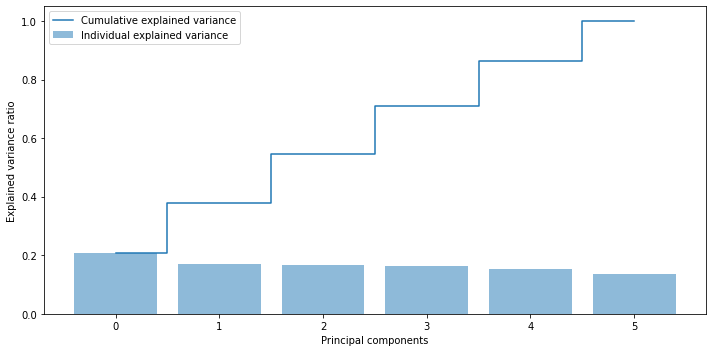

In [22]:
import numpy as np
import matplotlib.pyplot as plt
# Calculate explained variance and cumulative explained variance
explained_variance = eigenvalues / np.sum(eigenvalues)
cumulative_explained_variance = np.cumsum(explained_variance)

# Convert explained variance and cumulative explained variance to a list for plotting
explained_variance_list = explained_variance.tolist()
cumulative_explained_variance_list = cumulative_explained_variance.tolist()

# Plotting
plt.figure(figsize=(10, 5))

# Individual explained variance
plt.bar(range(len(explained_variance_list)), explained_variance_list, alpha=0.5, align='center', label='Individual explained variance')

# Cumulative explained variance
plt.step(range(len(cumulative_explained_variance_list)), cumulative_explained_variance_list, where='mid', label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [28]:
projected_data = pca_model.transform(scaled_data).select("pca_features")

# Display the projected data
projected_data.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                             |
+-------------------------------------------------------------------------------------------------------------------------+
|[-0.9701426508790059,-0.11855505433292926,1.2888095499347487,0.4253605814080012,0.273801045379327,0.13236770432637648]   |
|[-0.3071971000294026,-0.6033096334747959,0.12007968989656864,0.2704212066136684,-0.26149954604839376,0.09757398310350004]|
|[-1.120968753071569,1.675194999693568,-1.8378289537937886,-3.2966334250122205,0.5158097762203011,0.2620634006864085]     |
|[-0.27643738255580763,1.3702220711599964,-0.4717596404191539,0.4133592148056165,0.09777786427001443,1.6594180170812072]  |
|[-3.018567801327912,0.582643939140457,0.21214603221518594,-3.214605232436968,2.045646950772653,-0.9193855261813888]      |
|[-3.545

In [28]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



# Split the data
(train_data, test_data) = scaled_data.randomSplit([0.8, 0.2], seed=42)


In [31]:
# Define the model
dt = DecisionTreeClassifier(labelCol="tsunami", featuresCol="features", seed=42)

# Parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [10, 20, 30, 40, 50]) \
    .addGrid(dt.minInstancesPerNode, [2, 5, 10, 20]) \
    .build()

# Cross validation
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="tsunami", metricName="accuracy"),
                          numFolds=5)

# Train model
cvModel = crossval.fit(train_data)

# Get the best model and parameters
bestModel = cvModel.bestModel
bestParams = bestModel.extractParamMap()

# Get the best accuracy (optional: you would need to run the evaluator on a validation set)
evaluator = MulticlassClassificationEvaluator(labelCol="tsunami", predictionCol="prediction", metricName="accuracy")
bestAccuracy = evaluator.evaluate(bestModel.transform(test_data))

print(bestParams, bestAccuracy)

23/10/10 09:29:30 WARN CacheManager: Asked to cache already cached data.
23/10/10 09:29:30 WARN CacheManager: Asked to cache already cached data.


IllegalArgumentException: tsunami does not exist. Available: magnitude, depth, latitude, longitude, number_of_buildings_impacted, economic_loss, features, scaled_features, CrossValidator_8d4f1be48ac2_rand

Silhouette with squared euclidean distance = 0.21875652097471357


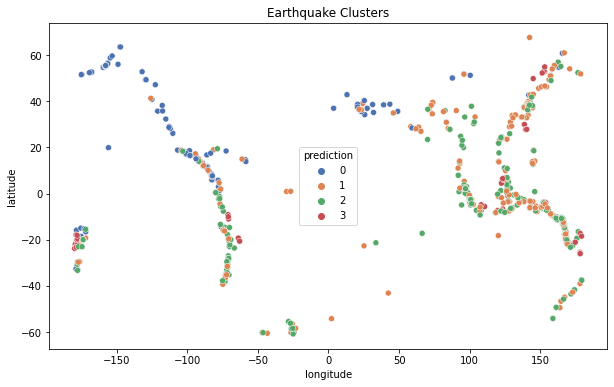